In [1]:
##### Config

import datetime
import pandas as pd
from pyspark import SparkConf, SparkContext, HiveContext
import re
import numpy as np
import pandas as pd
import sklearn,sklearn.metrics
import datetime
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.classification import LogisticRegressionWithSGD, NaiveBayes, NaiveBayesModel
import scipy.sparse as sps
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.evaluation import BinaryClassificationMetrics


hive_config_query = '''
set hive.vectorized.execution.enabled=true;
set hive.vectorized.execution.reduce.enabled = true;
set mapreduce.map.memory.mb=4096;
set mapreduce.map.child.java.opts=-Xmx4g;
set mapreduce.task.io.sort.mb=1024;
set mapreduce.reduce.child.java.opts=-Xmx4g;
set mapreduce.reduce.memory.mb=7000;
set mapreduce.reduce.shuffle.input.buffer.percent=0.5;
set mapreduce.input.fileinputformat.split.minsize=536870912;
set mapreduce.input.fileinputformat.split.maxsize=1073741824;
set hive.optimize.ppd=true;
set hive.merge.smallfiles.avgsize=536870912;
set hive.merge.mapredfiles=true;
set hive.merge.mapfiles=true;
set hive.hadoop.supports.splittable.combineinputformat=true;
set hive.exec.reducers.bytes.per.reducer=536870912;
set hive.exec.parallel=true;
set hive.exec.max.created.files=10000000;
set hive.exec.compress.output=true;
set hive.exec.dynamic.partition.mode=nonstrict;
set hive.exec.max.dynamic.partitions=1000000;
set hive.exec.max.dynamic.partitions.pernode=100000;
set io.seqfile.compression.type=BLOCK;
set mapreduce.map.failures.maxpercent=5;
'''
try:
    sc.stop()
except NameError:
    pass

conf = (SparkConf()
        .set("spark.executor.instances", 4)
        .set("spark.driver.maxResultSize", "8g")
        .set('spark.driver.memory','8g')
        .set("spark.executor.memory", '4g')
        .set("spark.yarn.executor.memoryOverhead", 1048)
        .set("spark.akka.frameSize", '1024')        
       )
sc = SparkContext(conf=conf)
hc = HiveContext(sc)

In [5]:
train = hc.sql('select * from user_kposminin.appl_ages_train_2').toPandas()
test = hc.sql('select * from user_kposminin.appl_ages_test_2').toPandas()

In [3]:
def cv(clf, X, y, folds = 5, metrics = 'roc_auc,pr_auc'):
    '''calc cross-validation metrics for clf classfier on X,y data.
       clf must support predict_proba method.
       Returns dictionary with metrics values on each fold.
    '''
    assert X.shape[0] == len(y), 'X and y lengths doesnt match'
    idx = range(X.shape[0])
    np.random.shuffle(idx)
    fold_idx = []
    for i in range(folds):
        fold_idx.append(idx[i*len(idx)/folds:(i+1)*len(idx)/folds])
    res = {k:[] for k in metrics.split(',')}
    
    for i in range(folds):
        train_idx = reduce(lambda x,y: x+y,(fold_idx[:i] + fold_idx[(i+1):]))
        valid_idx = fold_idx[i]
        
        clf.fit(X[train_idx],y[train_idx])
        valid_pred = clf.predict_proba(X[valid_idx])[:,1]
        
        if('roc_auc' in metrics):
            res['roc_auc'].append(
                sklearn.metrics.roc_auc_score(
                  y_true = y[valid_idx],
                  y_score = valid_pred
                )
            )
        if('pr_auc' in metrics):
            res['pr_auc'].append(
                sklearn.metrics.average_precision_score(
                  y_true = y[valid_idx],
                  y_score = valid_pred
                )
            )
            
    return res

In [15]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((3781692, 4), (3781692,), (233833, 4), (3781692,))

In [16]:
from sklearn.feature_extraction import DictVectorizer
import os
import sklearn, sklearn.cross_validation
from pylightgbm.models import GBMClassifier
import sklearn.model_selection

start = datetime.datetime.now()
exec_path = "/opt/share/LightGBM-master/lightgbm"
os.environ["LIGHTGBM_EXEC"] = exec_path

feats = [u'max_score', u'avg_score', u'cnt', u'visit_count',u'good_url_avg_hour']

X_train, y_train = train[feat_cols].values, train['label'].values
X_test, y_test   =  test[feat_cols].values, test['label'].values

result = []
clf = GBMClassifier(
        exec_path=exec_path,
        min_data_in_leaf = 50,
       # is_unbalance = True,
        num_iterations = 600,
        bagging_fraction = 0.8,
        bagging_freq = 10,
        num_leaves = 16,
        learning_rate = 0.2,
        metric = 'auc',
        early_stopping_round = 10
        
    )
clf.fit(X_train,y_train, test_data=[(X_test, y_test)])

#result.append((i,feat_list[i], cv(clf, data[feats].values, df_train[label].values, folds = 5, metrics = 'roc_auc,pr_auc')))
#print(datetime.datetime.now())



[LightGBM] [Info] Finished loading parameters
[LightGBM] [Info] Finished loading data in 5.745677 seconds
[LightGBM] [Info] Number of postive: 49556, number of negative: 3732136
[LightGBM] [Info] Number of data: 3781692, number of features: 4
[LightGBM] [Info] Finished initializing training
[LightGBM] [Info] Started training...
[LightGBM] [Info] Iteration:1, valid_1 auc : 0.723567
[LightGBM] [Info] 0.434355 seconds elapsed, finished iteration 1
[LightGBM] [Info] Iteration:2, valid_1 auc : 0.725728
[LightGBM] [Info] 0.848092 seconds elapsed, finished iteration 2
[LightGBM] [Info] Iteration:3, valid_1 auc : 0.726147
[LightGBM] [Info] 1.262182 seconds elapsed, finished iteration 3
[LightGBM] [Info] Iteration:4, valid_1 auc : 0.727655
[LightGBM] [Info] 1.673239 seconds elapsed, finished iteration 4
[LightGBM] [Info] Iteration:5, valid_1 auc : 0.727451
[LightGBM] [Info] 2.091664 seconds elapsed, finished iteration 5
[LightGBM] [Info] Iteration:6, valid_1 auc : 0.727692
[LightGBM] [Info] 2.5

In [ ]:
import numpy as np
from sklearn import datasets, metrics, model_selection


# Parameters
seed = 7376
np.random.seed(seed)  # for reproducibility


# 'exec_path' is the path to lightgbm executable

gbm = GBMClassifier(
        exec_path=exec_path,
        min_data_in_leaf = 100,
       # is_unbalance = True,
        num_iterations = 700,
        bagging_fraction = 0.8,
        bagging_freq = 10,
        num_leaves = 16,
        learning_rate = 0.2,
        metric = 'auc',
        early_stopping_round = 10,
        verbose = False
        
    )

param_grid = {
    'learning_rate': [0.2, 0.1, 0.04],
    'min_data_in_leaf': [10,100,500],
    'bagging_fraction': [0.5, 0.9],
    'num_leaves': [3,7,31,127],
    'num_iterations': [20,40,100,300,600]
}

scorer = metrics.make_scorer(metrics.accuracy_score, greater_is_better=True)
#scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True)
#clf = model_selection.GridSearchCV(gbm, param_grid, scoring=scorer, cv=2)
clf = model_selection.RandomizedSearchCV(gbm, param_grid, scoring=scorer, cv = 4, n_iter = 15)

clf.fit(X_train, y_train)

print("Best score: ", clf.best_score_)
print("Best params: ", clf.best_params_)

In [17]:
y_pred = clf.predict_proba(X_test)[:,1]

[LightGBM] [Info] Finished loading parameters
[LightGBM] [Info] Finished loading 44 models
[LightGBM] [Info] Finished initializing prediction
[LightGBM] [Info] Finished prediction


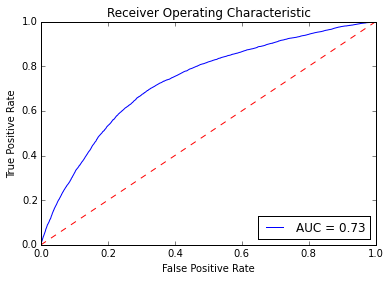

In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test, y_pred)
precision,recall, thres1 = sklearn.metrics.precision_recall_curve(y_test, y_pred)
roc_auc = sklearn.metrics.auc(fpr, tpr)


import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#a = sklearn.metrics.roc_curve(y_test,y_pred)

In [19]:
#y_control = np.array(sorted(zip(y_pred_aza,y_test_aza),reverse = True))
test_pred_labels = np.array(sorted(zip(y_pred,y_test),reverse = True))

In [34]:
print('Test: Scholars share and lift\n{:<10}\t{:<10}\t{:<10}'.format(*'quantile share lift'.split(' ')))
for q in [0.01,0.02,0.03,0.1,0.2,0.5,1]:
    print('{:<10.1%}\t{:<10.2%}\t{:<10.3}'.format(q,
                                                     test_pred_labels[:int(q*test_pred_labels.shape[0]),1].mean(),
                                                     test_pred_labels[:int(q*test_pred_labels.shape[0]),1].mean()/test_pred_labels[:,1].mean())
         )


Test: Scholars share and lift
quantile  	share     	lift      
1.0%      	11.68%    	4.49      
2.0%      	11.04%    	4.24      
3.0%      	9.97%     	3.83      
10.0%     	7.98%     	3.07      
20.0%     	6.73%     	2.59      
50.0%     	4.24%     	1.63      
100.0%    	2.60%     	1.0       


Простой классификатор дает AUC ROC 0.73. Попробуем еще лог регрессию

In [72]:
import pyspark.ml.feature as pmf
from pyspark.sql import functions as F
from pyspark.ml.classification import LogisticRegression

# Data prepartion. url_fragment a sbag of words. Hashing for dimension reduction + TFIDF
sdf_train = hc.sql('select * from user_kposminin.appl_ages_visits_mar_1')
sdf_test = hc.sql('select * from user_kposminin.appl_ages_visits_apr_test_1')

hashingTF = pmf.HashingTF(inputCol="ufl", outputCol="url_fragment_TF", numFeatures = 2**17)
sdf_train_TF = hashingTF.transform(sdf_train.groupBy('phone_num').agg(F.max('label').alias('label'),F.collect_list("url_fragment").alias('ufl')))
sdf_test_TF = hashingTF.transform(sdf_test.groupBy('phone_num').agg(F.max('label').alias('label'),F.collect_list("url_fragment").alias('ufl')))

idf = pmf.IDF(inputCol="url_fragment_TF", outputCol="features")
idfModel = idf.fit(sdf_train_TF)
sdf_train_TFIDF = idfModel.transform(sdf_train_TF)
sdf_test_TFIDF = idfModel.transform(sdf_test_TF)

#sdf_train_TFIDF.select("label", "features").show()



In [88]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(maxIter=10, regParam=0.01)

# Fit the model
lrModel = lr.fit(sdf_train_TFIDF)
test_pred = lrModel.transform(sdf_test_TFIDF)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('Test ROC AUC {}, ROC PR {}'.format(evaluator.evaluate(test_pred, {evaluator.metricName: "areaUnderROC"}), 
                                          evaluator.evaluate(test_pred, {evaluator.metricName: "areaUnderPR"})
                                         ))

Test ROC AUC 0.709745965471, ROC PR 0.0661287946177


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

lr = LogisticRegression(maxIter=10)

paramGrid = (ParamGridBuilder()
    .addGrid(lr.regParam, [0.1, 0.01,0]) 
    .addGrid(lr.maxIter, [10,50]) 
   .build())

crossval = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid,
                          evaluator = BinaryClassificationEvaluator(),
                          numFolds = 3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(sdf_train_TFIDF)

# Make predictions on test documents. cvModel uses the best model found (lrModel).
test_pred = cvModel.transform(sdf_test_TFIDF)

evaluator = BinaryClassificatilr.maxIteraluator(rawPredictionCol="rawPrediction")
print('Test ROC AUC {}, ROC PR {}'.format(evaluator.evaluate(test_pred, {evaluator.metricName: "areaUnderROC"}), 
                                          evaluator.evaluate(test_pred, {evaluator.metricName: "areaUnderPR"})
                                         ))
